In [ ]:
## Load packages

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import linearmodels as lm
from scipy import stats
from regpyhdfe import Regpyhdfe
from fixedeffect.fe import fixedeffect
from stargazer.stargazer import Stargazer
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
import gc
import glob
import time
import subprocess
import warnings
import dli

pd.options.mode.chained_assignment = None  # default='warn'

## Set directories

input = "<Directory>\\Data"
input_econ = "<Directory>\\Data\\Economic Data\\"
zip_dir = "<Directory>\\Data\\Financials"

output = "<Directory>\\Data\\"

res_out = "<Directory>\\Projects\\Systematic Macro Shocks\\Results"


#Daterange to be used:
    
#mindate = '09/31/2013'
#maxdate = '05/01/2022'
#maxdate = '01/01/2022'

#mindate = '09-30-2013'
mindate = '08-31-2013'
#maxdate = '04-30-2022'
#maxdate = '05-01-2022'
#maxdate = '12-31-2021'
maxdate = '09-30-2022'

#Set script directory to current working directory:
    
script = os.getcwd()
#os.chdir(script+'\\Data')
os.chdir('<Directory>')

In [4]:
## Load economic data:

#Economic policy uncertainty (Baker et al. 2016):
url="https://policyuncertainty.com/media/All_Country_Data.xlsx"
epu = pd.read_excel(url, skipfooter=29)

#Monetary policy uncertainty (Baker et al. 2016):
url="https://www.policyuncertainty.com/media/US_MPU_Monthly.xlsx"
mpu = pd.read_excel(url, skiprows=range(0), skipfooter=1)

#Climate policy uncertainty (Gavriilidis 2021):
#url="https://www.policyuncertainty.com/media/CPU%20index.csv"
#cpu = pd.read_csv(url, skiprows=range(2))
cpu = pd.read_csv(input_econ+"Climate_Policy_Uncertainty.csv", skiprows=range(2))  

#Geopolitical risk index:
url="https://www.matteoiacoviello.com/gpr_files/data_gpr_export.xls"
gr = pd.read_excel(url)

#Macroeconomic and financial uncertainty (Jurado et al. 2015 and Ludvigson et al. 2021):  
url="https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_202208Update.zip"
resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read()))
fintu = pd.read_excel(zipfile.open(zipfile.namelist()[0]), sheet_name='Total Financial Uncertainty')
fineu = pd.read_excel(zipfile.open(zipfile.namelist()[0]), sheet_name='Economic Financial Uncertainty')
mactu = pd.read_excel(zipfile.open(zipfile.namelist()[1]), sheet_name='Total Macro Uncertainty')
maceu = pd.read_excel(zipfile.open(zipfile.namelist()[1]), sheet_name='Economic Macro Uncertainty')
realtu = pd.read_excel(zipfile.open(zipfile.namelist()[2]), sheet_name='Total Real Uncertainty')
realeu = pd.read_excel(zipfile.open(zipfile.namelist()[2]), sheet_name='Economic Real Uncertainty')

#Twitter economic uncertainty (Baker et al. 2021): 
tweu = pd.read_excel(input_econ+"Twitter_Economic_Uncertainty.xlsx")     
    
#Monetary policy uncertainty (US):
mpu_us = pd.read_excel(input_econ+"HRS_MPU_monthly.xlsx") 

## Load other financial/economic data:

#Volatility index (VIX):
    
url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
vix = pd.read_csv(url)

#IHS purchasing manager index: 

#Logon and Authenticate to the Data Lake
dl = dli.connect()

#Loading Dataset
meta_ds = dl.datasets.get(short_code="PurchasingManagersIndexPMIMetadata")
ts_ds = dl.datasets.get(short_code="PurchasingManagersIndexPMITimeseries")

#Reading the Meta Data as a Dataframe
meta_df = meta_ds.dataframe(partitions=[f"as_of_date={meta_ds.last_datafile_at}"])
meta_df.sort_values('short_label', inplace=True)

#Check unique values of key columns and get the right meta information
regions=['Asia', 'Asia Excluding China, Japan', 'Asia Excluding China', 'Asia Excluding Japan',
         'China (mainland)', 'Developed Countries', 'Emerging Markets', 'Europe', 'European Union',
         'Eurozone', 'World', 'Japan', 'North America', 'United States']
meta_df = meta_df[(meta_df['economic_concept_name'].isin(['PMI', 'Headline'])) 
        & (meta_df['source_geographic_location_name'].isin(regions))
        & (meta_df['short_label'].str.contains('Composite')|meta_df['short_label'].str.contains('Manufacturing'))
        & (meta_df['series_type_name'] == 'Historical')]
 
#Reading the Time Series as a Dataframe
ts_df = ts_ds.dataframe(partitions=[f"as_of_date={ts_ds.last_datafile_at}"])

#Merge Timeseries with Metadata to get the required series 
df_PMI = pd.merge(ts_df, meta_df[['source_id', 'mnemonic', 'last_update', 
                                  'long_label', 'short_label', 
                                  'document_type', 'economic_concept_name',
                                  'source_geographic_location_name']], on="source_id")

    
## Merge data to one monthly dataset:

cpu['date'] = pd.to_datetime(cpu['date'], format='%b-%y')
cpu['month_id'] = pd.to_datetime(cpu['date']).dt.strftime('%Y-%m')

econ = cpu.copy(deep=True)
econ = econ[['month_id', 'cpu_index']]

mpu['month_id'] = pd.to_datetime(mpu[['Year', 'Month']].assign(DAY=1)).dt.strftime('%Y-%m') 
econ = pd.merge(econ, mpu.iloc[:,2:], on='month_id', how='outer')    
econ.sort_values(['month_id'], inplace=True)

mpu_us['Month'] = mpu_us['Month'].str.replace('m',' ')
mpu_us['month_id'] = pd.to_datetime(mpu_us['Month'], format='%Y %m').dt.strftime('%Y-%m')
econ = pd.merge(econ, mpu_us[['month_id', 'US MPU']], on='month_id', how='outer')    
econ.sort_values(['month_id'], inplace=True)

fintu['month_id'] = pd.to_datetime(fintu['Date']).dt.strftime('%Y-%m')
econ = pd.merge(econ, fintu[['month_id', 'h=1']], on='month_id', how='outer')   
econ.rename(columns={'h=1':'Financial Uncertainty'}, inplace=True)

mactu['month_id'] = pd.to_datetime(mactu['Date']).dt.strftime('%Y-%m')
econ = pd.merge(econ, mactu[['month_id', 'h=1']], on='month_id', how='outer')   
econ.rename(columns={'h=1':'Macro Uncertainty'}, inplace=True)

realtu['month_id'] = pd.to_datetime(realtu['Date']).dt.strftime('%Y-%m')
econ = pd.merge(econ, realtu[['month_id', 'h=1']], on='month_id', how='outer')   
econ.rename(columns={'h=1':'Real Uncertainty'}, inplace=True)
econ.sort_values(['month_id'], inplace=True)

tweu['month_id'] = pd.to_datetime(tweu['date']).dt.strftime('%Y-%m')
tweum = tweu.groupby(['month_id']).last().reset_index()
econ = pd.merge(econ, tweum[['month_id', 'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA']], on='month_id', how='outer')    
econ.sort_values(['month_id'], inplace=True)

vix['month_id'] = pd.to_datetime(vix['DATE']).dt.strftime('%Y-%m')
vix['VIX_mean'] = vix.groupby(['month_id'])['CLOSE'].transform('mean')
vix = vix.groupby(['month_id']).last().reset_index()
econ = pd.merge(econ, vix[['month_id', 'CLOSE', 'VIX_mean']], on='month_id', how='outer')
econ.rename(columns={'CLOSE':'VIX'}, inplace=True)   

df_PMI["month_id"] = df_PMI["date"].dt.strftime("%Y-%m")
df_PMI = df_PMI.pivot(index="month_id", columns="source_id", values="value")
df_PMI = df_PMI.reset_index()
df_PMI = df_PMI[['month_id', '88505325', '93625215']]
df_PMI.rename(columns={'88505325':'Global Composite (M+S) PMI Headline Adjusted', 
                       '93625215':'Global Manufacturing PMI Adjusted'}, inplace=True)
econ = pd.merge(econ, df_PMI, on='month_id', how='outer')


## Load climate-related data:

#Media climate change concern index:
mccc = pd.read_excel(input_econ+"Sentometrics_US_Media_Climate_Change_Index.xlsx", 
                     sheet_name='SSRN 2022 version (monthly)', skiprows=range(5)) 

#Climate change news index:
ccn = mccc = pd.read_excel(input_econ+"EGLKS_data.xlsx") 

<AxesSubplot:title={'center':'Macro Shocks Heat Map'}, xlabel='Shock2', ylabel='Shock1'>

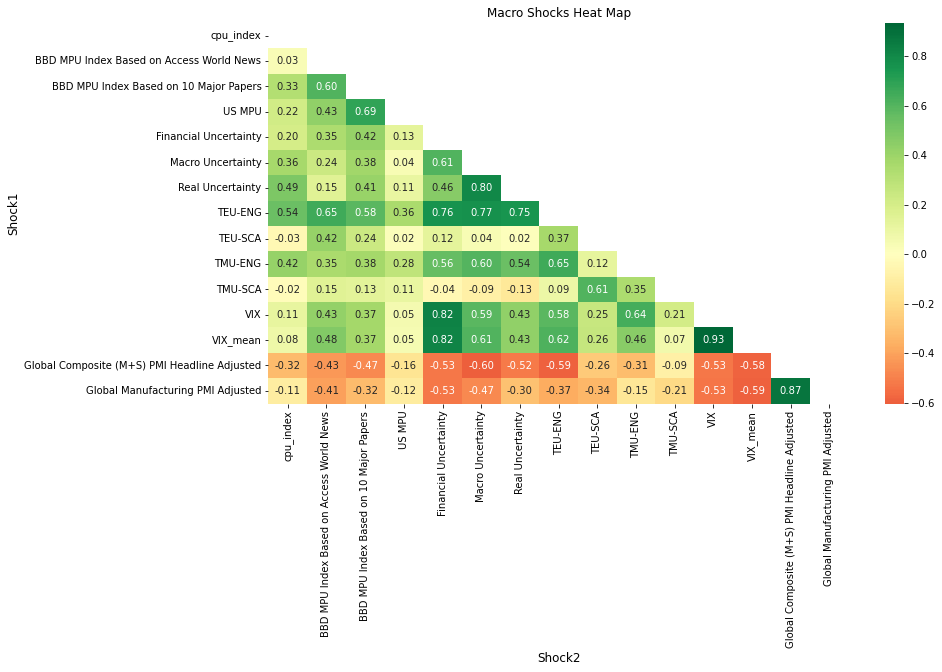

In [3]:
## Correlations between economic shock variables    
    
#ec = np.corrcoef(econ.loc[:,'cpu_index':'VIX_mean'])   
#ec = econ.loc[:,'cpu_index':'VIX_mean'].corr()
ec = econ.loc[:,'cpu_index':].corr()
#print(ec)

ec.index.name = 'Shock1' 
ec.columns.name = 'Shock2' 

fig, ax = plt.subplots(figsize=(13,7))
plt.title("Macro Shocks Heat Map",fontsize=12)
plt.xlabel('Shock1', fontsize = 12)
plt.ylabel('Shock2', fontsize = 12)
#sns.heatmap(ec)
#sns.heatmap(ec, mask=np.triu(ec))
#sns.heatmap(ec, mask=np.triu(ec), annot=True, fmt='.2f', center = 0, cmap=sns.diverging_palette(20,120,n=256))
sns.heatmap(ec, mask=np.triu(ec), annot=True, fmt='.2f', center = 0, cmap='RdYlGn')

In [5]:
## Load stock market data:    
 
ret = pd.read_csv(input+'\\Financials\\firm_returns_monthly.csv', low_memory=False)
#ind = pd.read_csv(input+'\\Financials\\industry_affiliation_monthly.csv', low_memory=False)
#ret = pd.read_csv(input+'\\Financials\\returns_monthly.csv', low_memory=False)
#ind = pd.read_csv(input+'\\Financials\\industries_monthly.csv', low_memory=False)
zipfile = ZipFile(input+'\\Financials\\industries.zip')
ind = pd.read_csv(zipfile.open(zipfile.namelist()[0]))  
print(ind.columns)

#ret = pd.merge(ret, ind, on=['issue_id', 'month_id', 'Date', 'company_name',
#                            'capital_iq', 'snlinstitutionid'])
#ret = pd.merge(ret, ind, on=['issue_id', 'month_id', 'company_name',
#                             'capital_iq', 'snlinstitutionid'], suffixes=['', '_ind'], indicator=True)
ret = pd.merge(ret, ind, on=['capital_iq', 'month_id'], suffixes=['', '_ind'], 
               indicator=True, how='inner')

print(ret['_merge'].value_counts())
ret.drop(['_merge'], axis=1, inplace=True)

try:
    ret = ret.drop(['Unnamed: 0'], axis = 1)
except:
    pass

ret = ret.rename(columns={'capital_iq':'CIQ_ID'})

ret.sort_values(['CIQ_ID', 'month_id'], inplace=True)
for m in ['market_cap', 'market_cap_usd']:
    ret[m] = ret.groupby('CIQ_ID')[m].shift(1)
    ret[m] = ret[m]/1000
    
#Duplicates in financial data: Drop if no price available or if not issue #1

#ret['dup'] = ret.duplicated(subset=['CIQ_ID', 'month_id'], keep=False)   
#ret = ret.drop(ret[(ret['dup']==True) & (ret['prccd'].isnull())].index)
#ret = ret.drop(['dup'], axis=1)

#ret.sort_values(['CIQ_ID', 'issue_id', 'month_id'], inplace=True)
#ret = ret.groupby(['CIQ_ID', 'month_id']).first().reset_index()

ind = ind.rename(columns={'capital_iq':'CIQ_ID'})
#ind = pd.merge(ind, ret[['issue_id', 'month_id', 'company_name', 'CIQ_ID', 'snlinstitutionid', 
#                         'prccd']], on=['issue_id', 'month_id', 'company_name', 'CIQ_ID', 
#                         'snlinstitutionid'], how='right', suffixes=['_ind', ''])
#ind = pd.merge(ind, ret[['issue_id', 'month_id', 'company_name', 'CIQ_ID', 'snlinstitutionid', 
#                         'prccd']], on=['issue_id', 'month_id', 'company_name', 'CIQ_ID'], how='right', suffixes=['_ind', ''])
#ind.drop(['prccd'], axis=1, inplace=True)
ind['month_id'] = pd.to_datetime(ind['month_id']).dt.to_period("M")


Index(['Unnamed: 0', 'capital_iq', 'month_id', 'Date', 'iso_code',
       'company_id', 'country', 'currency', 'industry', 'region', 'sector',
       'sub_industry', 'sub_sector', 'gticker', 'gvkey', 'calendarYear',
       'filingDate', 'fiscalYear'],
      dtype='object')
both          8402325
left_only           0
right_only          0
Name: _merge, dtype: int64


In [6]:
##Merge macroeconomic and stock market data

ret = pd.merge(ret, econ, on='month_id', how='left')
ret['month_id'] = pd.to_datetime(ret['month_id']).dt.to_period("M")
ret.sort_values(['CIQ_ID', 'month_id'], inplace=True)

print(ret.columns)

Index(['company_id', 'month_id', 'Date', 'cusip', 'company_name', 'isin',
       'issue_id', 'ticker', 'CIQ_ID', 'gvkey', 'prccd_usd', 'prccd',
       'prccd_unadj_usd', 'prccd_unadj', 'cshtrm', 'cshoc', 'cshoc_unadj',
       'market_cap_usd', 'market_cap', 'ret_usd', 'ret', 'Date_ind',
       'iso_code', 'company_id_ind', 'country', 'currency', 'industry',
       'region', 'sector', 'sub_industry', 'sub_sector', 'gticker',
       'gvkey_ind', 'calendarYear', 'filingDate', 'fiscalYear', 'cpu_index',
       'BBD MPU Index Based on Access World News',
       'BBD MPU Index Based on 10 Major Papers', 'US MPU',
       'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty',
       'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA', 'VIX', 'VIX_mean'],
      dtype='object')


In [7]:
#Import ESG data

import csa_data_exec

csa = csa_data_exec.csa_import()

csa = csa[csa['_merge']=='both']

#csa.drop(['CAM_ID', 'CAM_NAME', 'CAM_TYPE', 'EVR_PUBLISH_TIME', 'EVR_ID',
#          'aspect_type', 'Potential Score Contribution Combined', 'Data Availability Public',
#          'Data Availability Private', 'Data Availability Combined', 'SCORE_IMP_TEMP', '_merge'], 
#          axis=1, inplace=True)
csa.drop(['Potential Score Contribution Combined', 'Data Availability Public',
          'Data Availability Private', 'Data Availability Combined', 'SCORE_IMP_TEMP', '_merge'], 
          axis=1, inplace=True)
gc.collect()

0

In [10]:
#Only keep the respective level of aggregated scores

#csa['CAM_TYPE'].value_counts()
#csa = csa[csa['CAM_TYPE']=='CA']

question = csa[csa['QUESTION'].notnull()]
criterion = csa[(csa['QUESTION'].isnull())&(csa['CRITERION'].notnull())]
dimension = csa[(csa['QUESTION'].isnull())&(csa['CRITERION'].isnull())&(csa['DIMENSION'].notnull())]
esg = csa[(csa['QUESTION'].isnull())&(csa['CRITERION'].isnull())&(csa['DIMENSION'].isnull())]

#Set the score to be used in sorting:

#Potential choices are: 
#SCORE: classical scores, SCORE_IMP: imputed scores, SCORE_IMP_NP: imputed scores without disclosure penalization

#score = 'SCORE'
#score = 'SCORE_IMP'
#score = 'SCORE_IMP_NP'

In [11]:
#Prepare wide tables

#In wide tables the different score levels are next to each other instead of below each other, this enables sorting for multiple variables 

#ESG

esg.loc[esg['DIMENSION'].isnull(), 'DIMENSION'] = "ESG"

esg.sort_values(['CSF_LCID', 'month_id'], inplace=True)
firm_inf = esg.groupby(['CSF_LCID', 'month_id'])['INDUSTRY', 'INDUSTRYGROUP', 
                                                 'CSF_LONGNAME', 'ISIN', 'GVKEY', 
                                                 'CIQ_ID', 'COUNTRYNAME', 'DJREGION',
                                                 'Date', 'CAM_YEAR', 'ASOF_DATE'].last()

#esg = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
#                      columns='DIMENSION', values=score)

esgs = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
                      columns='DIMENSION', values='SCORE')
esgi = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
                      columns='DIMENSION', values='SCORE_IMP')
esgn = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
                      columns='DIMENSION', values='SCORE_IMP_NP')
esg = pd.merge(esgs, esgi, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
esg = pd.merge(esg, esgn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

esg = pd.merge(esg, firm_inf, left_index=True, right_index=True)
esg = esg.reset_index()

del esgs
del esgi
del esgn

#Dimension:
 
dimension.replace({'DIMENSION':{'Economic Dimension':'Governance & Economic Dimension'}},
                 inplace=True)

#dimension = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
#                                  columns='DIMENSION', values=score)
   
dimensions = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='DIMENSION', values='SCORE')
dimensioni = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='DIMENSION', values='SCORE_IMP')
dimensionn = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='DIMENSION', values='SCORE_IMP_NP')
dimension = pd.merge(dimensions, dimensioni, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
dimension = pd.merge(dimension, dimensionn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

dimension = pd.merge(dimension, firm_inf, left_index=True, right_index=True)
dimension = dimension.reset_index()

del dimensions
del dimensioni
del dimensionn

#Criterion

#Only include criteria that have been used in the most recent CSA data vintage

csas = csa.groupby(['CAM_YEAR', 'ASP_LCID']).last()
csas.sort_values(['ASP_LCID', 'CAM_YEAR'], inplace=True)
csas = csas.reset_index()

csac = csas[(csas['QUESTION'].isnull())&(csas['CRITERION'].notnull())]
csacl = csac[csac['CAM_YEAR']==2021]
csacl = csacl[['ASP_LCID', 'CRITERION']]

criterion.drop(['DIMENSION', 'CRITERION', 'QUESTION'], axis=1, inplace=True)
criterion = pd.merge(criterion, csacl, on=['ASP_LCID'], how='inner')

#Only use criteria that have been available in at least the last 6 years

vc = csac['CRITERION'].value_counts()
vc = vc[vc>=6].reset_index()
vc.rename(columns={'index':'CRITERION',
                   'CRITERION':'CRITERIONYEARS'},inplace=True)

criterion = pd.merge(criterion, vc, on=['CRITERION'], how='inner')

firm_inf = criterion.groupby(['CSF_LCID', 'month_id'])['INDUSTRY', 'INDUSTRYGROUP', 
                                                       'CSF_LONGNAME', 'ISIN', 'GVKEY', 
                                                       'CIQ_ID', 'COUNTRYNAME', 'DJREGION',
                                                       'Date', 'CAM_YEAR', 'ASOF_DATE',
                                                       'CRITERIONYEARS'].last()

#criterion = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
#                                  columns='CRITERION', values=score)

#crit = ['Biodiversity', 'Brand Management', 'Climate Strategy', 'Corporate Governance',
crit = ['Corporate Governance', 'Climate Strategy',
'Customer Relationship Management', 'Environmental Policy & Management Systems', 
'Environmental Reporting', 'Innovation Management', 'Supply Chain Management']

criterions = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='CRITERION', values='SCORE')
criterioni = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='CRITERION', values='SCORE_IMP') 
criterionn = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='CRITERION', values='SCORE_IMP_NP')                                  
criterions = criterions[crit]
criterioni = criterioni[crit]
criterionn = criterionn[crit]
criterion = pd.merge(criterions, criterioni, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
criterion = pd.merge(criterion, criterionn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

criterion = pd.merge(criterion, firm_inf, left_index=True, right_index=True)
criterion = criterion.reset_index()

del criterions
del criterioni
del criterionn

#Question

#Only include questions that have been used in the most recent CSA data vintage
#Some question have been renamed, however, they have the same aspect identifier

csaq = csas[csas['CAM_YEAR']==2021]
csaq = csaq[csaq['QUESTION'].notnull()]
csaq = csaq[['ASP_LCID', 'QUESTION']]

question.drop(['DIMENSION', 'CRITERION', 'QUESTION'], axis=1, inplace=True)
question = pd.merge(question, csaq, on=['ASP_LCID'], how='inner')

#Only use questions that have been available in at least the last 6 years

vc = csas['QUESTION'].value_counts()
vc = vc[vc>=6].reset_index()
vc.rename(columns={'index':'QUESTION',
                   'QUESTION':'QUESTIONYEARS'},inplace=True)

question = pd.merge(question, vc, on=['QUESTION'], how='inner')
   
firm_inf = question.groupby(['CSF_LCID', 'month_id'])['INDUSTRY', 'INDUSTRYGROUP', 
                                                     'CSF_LONGNAME', 'ISIN', 'GVKEY', 
                                                     'CIQ_ID', 'COUNTRYNAME', 'DJREGION',
                                                     'Date', 'CAM_YEAR', 'ASOF_DATE', 
                                                     'QUESTIONYEARS'].last()

#question = question.pivot_table(index=['CSF_LCID', 'month_id'], 
#                                columns='QUESTION', values=score)

#qu = ['Climate Change Strategy', 'Climate Strategy Impacts', 'Corruption & Bribery',
qu = ['Corruption & Bribery',
'Direct Greenhouse Gas Emissions (Scope 1)', 'ESG Integration in SCM Strategy',
'Environmental Reporting - Assurance', 'Environmental Reporting - Coverage',
'Financial Opportunities Arising from Climate Change',
'Financial Risks of Climate Change', 'Indirect Greenhouse Gas Emissions (Scope 2)',
'Sensitivity Analysis & Stress Testing (including Water and Climate)',
'Supply Chain Risk Exposure', 'Waste Disposal', 'Water Use']
#'Internal Carbon Pricing', 'Process Innovations', 'Environmental Violations' 

questions = question.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='QUESTION', values='SCORE')
questioni = question.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='QUESTION', values='SCORE_IMP')  
questionn = question.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='QUESTION', values='SCORE_IMP_NP')                                  
questions = questions[qu]
questioni = questioni[qu]
questionn = questionn[qu]
question = pd.merge(questions, questioni, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
question = pd.merge(question, questionn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

question = pd.merge(question, firm_inf, left_index=True, right_index=True)
question = question.reset_index()

del questions
del questioni
del questionn

gc.collect()

63

In [12]:
#Industry-demeaned and standardized levels

ind.rename(columns={'capital_iq':'CIQ_ID'}, inplace=True)

def industry_adjust(data):
    data = pd.merge(data, ind[['CIQ_ID', 'month_id', 'sector', 'sub_sector']], on=['CIQ_ID', 'month_id'], how='left')

    var_name = list(data.loc[:,'month_id':'INDUSTRY'].columns)
    var_name = var_name[1:-1]
    
    data.sort_values(['CSF_LCID', 'month_id'], inplace=True)

    #print(data.columns)
    
    for v in var_name:
        #Industry-demeaned:
        data[v+'_ind'] = data.groupby(['INDUSTRY', 'CAM_YEAR'])[v].transform('mean')
        data[v+'_dm'] = data[v]-data[v+'_ind']

        #Standardized:
        data[v+'_mean'] = data.groupby(['CAM_YEAR'])[v].transform('mean')
        data[v+'_sd'] = data.groupby(['CAM_YEAR'])[v].transform('std')
        data[v+'_std'] = (data[v]-data[v+'_mean'])/data[v+'_sd']

        #Industry-demeaned standardized value: 
        data[v+'_inda'] = data.groupby(['CAM_YEAR'])[v+'_dm'].transform('mean')
        data[v+'_sda'] = data.groupby(['CAM_YEAR'])[v+'_dm'].transform('std')
        data[v+'_stdm'] = (data[v+'_dm']-data[v+'_inda'])/data[v+'_sda']

        #Sector-demeaned:
        data[v+'_sec'] = data.groupby(['sector', 'CAM_YEAR'])[v].transform('mean')
        data[v+'_dms'] = data[v]-data[v+'_sec']

        #Adjusted:
        data[v+'_us'] = -(100-data[v])

        data.drop([v+'_ind', v+'_sd', v+'_inda', v+'_sda', v+'_sec', v+'_mean'], axis=1, inplace=True)
        #data.drop([v+'_sd', v+'_mean'], axis=1, inplace=True)
        
    return data

question = industry_adjust(question)
criterion = industry_adjust(criterion)
dimension = industry_adjust(dimension)
esg = industry_adjust(esg)

del ind
gc.collect()

0

In [12]:
#Determine the type of CSA data to be analyzed:

#Possible choices are: esg, dimension, criterion, question
    
data = dimension.copy(deep=True)

#Levels:
var_name = list(data.loc[:,'month_id':'INDUSTRY'].columns)
var_name = var_name[1:-1]

#Industry-demeaned levels:
var_name_dm = list(data.loc[:,data.columns.str.endswith('_dm')].columns)

#Standardized levels:
var_name_sd = list(data.loc[:,data.columns.str.endswith('_std')].columns)

#Industry-demeaned and full-sample standardized levels:
var_name_sdm = list(data.loc[:,data.columns.str.endswith('_stdm')].columns)

#Sector-demeaned levels:
#var_name_dms = list(data.loc[:,data.columns.str.endswith('_dms')].columns)

#Adjusted levels:
var_name_us = list(data.loc[:,data.columns.str.endswith('_us')].columns)

try:
    data.drop(['_merge'], axis=1, inplace=True)
except:
    pass

data['month_id'] = pd.to_datetime(data['Date']) - pd.DateOffset(months=-1)
data['month_id'] = pd.to_datetime(data['month_id']).dt.to_period("M")

print('The following variables are analyzed: ' + str(var_name))

The following variables are analyzed: ['Environmental Dimension', 'Governance & Economic Dimension', 'Social Dimension', 'Environmental Dimension Imp', 'Governance & Economic Dimension Imp', 'Social Dimension Imp', 'Environmental Dimension NP', 'Governance & Economic Dimension NP', 'Social Dimension NP']


In [18]:
#Prepare data filtering:

#zipfile = ZipFile(zip_dir+'\\returns_daily.zip')
    
#ret = pd.read_csv(zipfile.open(zipfile.namelist()[0])) 
#ret = pd.read_csv(input+'\\Financials\\returns_daily.csv', dtype={'issue_id': 'str'})
#ret = ret[['Date','issue_id','ret_usd','ret','prccd','cshtrd','month_id']]    

#ret['year_id'] = pd.to_datetime(ret['Date']).dt.strftime('%Y') 
#ret['issue_id'] = ret['issue_id'].astype(str)   

#ret['ret0'] = ret['ret'].mask(ret['ret'].ne(0))
 
#Number of 0 returns per country and day or per firm and year

#countf = ret.groupby(['issue_id','year_id'])['ret0'].count()
#countft = ret.groupby(['issue_id','year_id'])['ret'].count()

#countf = pd.merge(countf, countft, left_index=True, right_index=True)    
#countf['perf'] = countf['ret0']/countf['ret']   
#countf = countf['perf'].reset_index()

#del ret

countf = pd.read_csv(input+'\\Financials\\zero_return_filter.csv', low_memory=False)

gc.collect()

74

In [19]:
#Apply filters:

#Winsorize returns by month at 1% and 99% percentiles
#Set max return to 300% if cumulative 2 month return less than 50% 
#Set min excess return to -100%

print(len(ret))

def month_return_adjust(rd, ret_vars):
    for r in ret_vars:
        rd[r+'2'] = ((1+rd[r])*(1+rd[r].shift())-1)*100
        rd[r] = rd[r]*100
        #rd[r] = rd.groupby('month_id')[r].transform(lambda x: stats.mstats.winsorize(x, 
        #                                                                             limits=[0.01, 0.01]))
        #rd[r] = rd.groupby('month_id')[r].transform(lambda x: np.maximum(x.quantile(.01), 
        #                                                                 np.minimum(x, x.quantile(.99))))
        #rd.loc[(rd[r]>300)&(rd[r+'2']<50),r] = 300 
        rd.loc[(rd[r]>300)&(rd[r+'2']<50),r] = np.nan
        rd.loc[rd[r]<-100,r] = -100 
    
    return rd

ret.sort_values(['CIQ_ID', 'month_id'], inplace=True)

ret = month_return_adjust(ret, ['ret', 'ret_usd'])

#Drop small and illiquid firms:

ret = ret[ret['cshtrm']!=0]
#ret = ret[ret['prccd_usd']>1]
#ret = ret[ret['market_cap_usd']>1]
#ret = ret[~((ret['prccd_usd']<0.5) & (ret['market_cap_usd']<1))]
print(len(ret))

#Drop if more than 30% zero return days per year

countf = countf.rename(columns={'capital_iq':'CIQ_ID'})

ret['year_id'] = pd.to_datetime(ret['Date']).dt.strftime('%Y').astype(int)
#ret['year_id'] = pd.to_datetime(ret['Date']).dt.strftime('%Y') 
ret = pd.merge(ret, countf, on=['CIQ_ID','year_id'])
ret = ret[ret['perf']<0.3]
print(len(ret))

#Number of firms per country and month, require at least 10:

firms = ret.groupby(['country', 'month_id'])['ret'].count()
firms = firms.reset_index()
firms.rename(columns={'ret':'firmno'}, inplace=True)

ret = pd.merge(ret, firms, on=['country', 'month_id'], how='outer')
ret = ret[ret['firmno']>=10]
print(len(ret))

#Keep data with CSA values:
    
#ret = ret[ret['CSF_LCID'].notnull()]
#print(len(ret))

gc.collect()

8653076
8653076
5881306
5855911


138

In [ ]:
#Apply filters:

#Winsorize returns by month at 1% and 99% percentiles
#Set max return to 300% if cumulative 2 month return less than 50% 
#Set min excess return to -100%

#def month_return_adjust(rd, ret_vars):
#    for r in ret_vars:
#        rd[r+'2'] = ((1+rd[r])*(1+rd[r].shift())-1)*100
#        rd[r] = rd[r]*100
#        rd.loc[(rd[r]>300)&(rd[r+'2']<50),r] = np.nan
#        rd.loc[rd[r]<-100,r] = -100 
    
#    return rd

#data.sort_values(['CIQ_ID', 'month_id'], inplace=True)

#data = month_return_adjust(data, ['ret', 'ret_usd'])

#Drop small and illiquid firms:

#data = data[data['cshtrd']!=0]
#print(len(data))

#Drop if more than 30% zero return days per year

#data['year_id'] = pd.to_datetime(data['Date']).dt.strftime('%Y') 
#data = pd.merge(data, countf, on=['issue_id','year_id'])
#data = data[data['perf']<0.3]
#print(len(data))

#Number of firms per country and month, require at least 10:

#firms = data.groupby(['country', 'month_id'])['ret'].count()
#firms = firms.reset_index()
#firms.rename(columns={'ret':'firmno'}, inplace=True)

#data = pd.merge(data, firms, on=['country', 'month_id'], how='outer')
#data = data[data['firmno']>=10]
#print(len(data))

#Keep data with CSA values:
    
#data = data[data['CSF_LCID'].notnull()]

#print(len(data))
#gc.collect()

In [21]:
#Merge financial data with csa data

data = pd.merge(ret, data, on=['CIQ_ID', 'month_id'], 
                how='outer', suffixes=['', '_csa'], indicator=True)

#Keep specific dates

data = data[pd.to_datetime(data['Date']) > mindate]
data = data[pd.to_datetime(data['Date']) < maxdate]

data.sort_values(['CIQ_ID', 'month_id'], inplace=True)

print(data['_merge'].value_counts())
gc.collect()

#Forward fill, csa data to the next 24 months, industry data generally

info = [x for x in list(data.loc[:,'INDUSTRY':'CAM_YEAR'].columns) if x != 'CIQ_ID']

#Number of months to forward scores:
fw=24

data[['CSF_LCID', 
      'CAM_YEAR']] = data.groupby(['CIQ_ID'])[['CSF_LCID', 'CAM_YEAR']].ffill(limit=fw)
data[info] = data.groupby(['CIQ_ID'])[info].ffill()
data[var_name] = data.groupby(['CIQ_ID'])[var_name].ffill(limit=fw)
#data[var_name_d] = data.groupby(['CIQ_ID'])[var_name_d].ffill(limit=fw)
data[var_name_dm] = data.groupby(['CIQ_ID'])[var_name_dm].ffill(limit=fw)
data[var_name_sd] = data.groupby(['CIQ_ID'])[var_name_sd].ffill(limit=fw)
data[var_name_sdm] = data.groupby(['CIQ_ID'])[var_name_sdm].ffill(limit=fw)
#data[var_name_dms] = data.groupby(['CIQ_ID'])[var_name_dms].ffill(limit=fw)
data[var_name_us] = data.groupby(['CIQ_ID'])[var_name_us].ffill(limit=fw)

#print(data.describe())
summary = data.describe()
len(data)

#Keep data with CSA values:
    
data = data[data['CSF_LCID'].notnull()]
print(len(data))

gc.collect()

left_only     2929693
both            49178
right_only          0
Name: _merge, dtype: int64
551670


0

In [35]:
# Value-weighted cross-sectional average scores 

data['mcap_sum'] = data.groupby(['month_id'])['market_cap_usd'].transform('sum')
data['mcap_w'] = data['market_cap_usd']/data['mcap_sum']

variables = list(data.loc[:, data.columns.str.endswith('_us')].columns)

for v in variables:
    data[v+'_mw'] = data[v]*data['mcap_w']
    data[v+'_w'] = data.groupby(['month_id'])[v+'_mw'].transform('sum')
    
    data[v] = data[v] - data[v+'_w']
    #data[v+'_dm'] = data[v] - data[v+'_w']
    data.drop([v+'_mw', v+'_w'], axis=1, inplace=True)
    #data[v+'_t'] = data[v+'_dm']*data['mcap_w']
    #data[v+'_t'] = data.groupby(['month_id'])[v+'_t'].transform('sum')

In [33]:
##Save the relevant dataset:

A = data.count()
data.to_csv(output + 'dimension' + '_dataset.csv')

In [23]:

def fmb_reg_var(df,time_id,depv,indepv,nw=None,num=None,sam=None,regtype='OLS', wt=None):
        
    """
    Fama-MacBeth cross-sectional regressions 
    Can be used for estimation of cross-sectional/slope factors
    
    Assumption of columns order in df: time_id, dependent variable, independent variables
    
    Parameters:
        
    df: DataFrame
    time_id: string ['Date'] 
    dep: dependent variable
    indep: independent variables
    nw: numeric value [time lags to compute Newey-West adjusted SEs]
    num: numeric value [percentage of full sample to be available in interval [0,1]]
    sam: numeric value [percentage of monthly sample to be available in interval [0,1]]
    regtype: Regression type, either OLS or WLS, in case of WLS need to specify weights parameter
    wt: WLS weights variable

    Examples:
    fmb, tb, reg = fmb_reg(data,'month_id')
    fmb, tb, reg = fmb_reg(data,'month_id', nw=6, num=0.5, sam=0.5)
    fmb, tb, reg = fmb_reg(data,'month_id', regtype='WLS', wt=['market_cap_usd'])
    """
    
    if num:
        n = df.notnull().sum()
        df = df[list(n.index[n > len(df)*num])] 

    ts = sorted(df[time_id].unique())
    betas = list()
    rsquared = list()
    nobs = list()
    
    #One cross-sectional regression in each time period

    for x in ts:
        sample = df[df[time_id] == x]
        sample = sample.dropna(axis=1, how='all')
        if sam:
            s = sample.count()
            s = s[s>(sample.count().max())*sam].index.to_list()
            sample = sample[s]
            sample = sample.dropna(axis=0)
        else:
            sample = sample.dropna(axis=0)
        
        if regtype == 'OLS':
            #res = smf.ols(formula, sample).fit()
            res = sm.OLS(sample[depv],sm.add_constant(sample[indepv])).fit()
        elif regtype == 'WLS':
            res = sm.WLS(sample[depv],sm.add_constant[indepv],
                         weights=np.array(sample[wt])).fit()
                         #weights=1./np.array(sample[wt])).fit()

        betas.append(res.params)
        rsquared.append(res.rsquared)
        nobs.append(res.nobs)
        
    rsquared = sum(rsquared)/len(rsquared)
    nobs = round(sum(nobs)/len(nobs))

    params = dict()
    tvalues = dict()
    fnobs = dict()
    regress = dict()
    regs = []
    
    #Computing sample average of coefficients

    indep = []
    for b in betas:
        var = list(b.index.values)  
        indep.extend(var)
    indep = indep[0:(len(indepv)+1)]
    
    i = 0
    #if smf.ols: for v in formula.split('~')[1].split('+'):
    #for v in np.unique(indep).tolist():
    for v in indep:
        i += 1
        #v = v.strip()
        #if v == '1':  # No intercept
            #continue
        beta_df = pd.DataFrame([b[v] for b in betas if v in b],
                               columns=['var'])
        if nw:
            res = smf.ols('var ~ 1', beta_df).fit(cov_type='HAC',
                                                  cov_kwds={'maxlags': nw})
        else:
            res = smf.ols('var ~ 1', beta_df).fit()
            
        regress[i] = res
        regs.append(res)
        
        params[v] = res.params['Intercept']
        tvalues[v] = res.tvalues['Intercept']
        fnobs[v] = res.nobs

    tbl = Stargazer(regress.values())

    results = pd.DataFrame.from_dict(params, orient='index')
    results = pd.merge(results, pd.DataFrame.from_dict(tvalues, orient='index'),
                       left_index=True, right_index=True)
    results = pd.merge(results, pd.DataFrame.from_dict(fnobs, orient='index'),
                       left_index=True, right_index=True)
    results.columns=['coef','t-stat','nobs']
    
    return results, tbl, regress

In [ ]:
##Analysis

#os.chdir('C:\\Users\\LUKAS_ZIMMERMANN\\OneDrive - S&P Global\\Projects')

import finfunc

reg_vars = list(data.loc[:,'CSF_LCID':'INDUSTRY'].columns[1:-1])
print(reg_vars)
reg_vars.extend([s + '_dm' for s in reg_vars]+[s + '_std' for s in reg_vars]+[s + '_stdm' for s in reg_vars]+[s + '_us' for s in reg_vars])

mac_vars = ['cpu_index', 'BBD MPU Index Based on Access World News', 'BBD MPU Index Based on 10 Major Papers', 'US MPU',
            'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty', 'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA', 'VIX', 'VIX_mean',
            'Global Composite (M+S) PMI Headline Adjusted', 'Global Manufacturing PMI Adjusted']

id_vars = ['month_id', 'ret_usd']
id_vars.extend(reg_vars)
id_vars.extend(mac_vars)

regdata = data[id_vars]

#regdata = data[['month_id', 'ret_usd', 'Environmental Dimension', 'Environmental Dimension Imp', 'Environmental Dimension_dm', 'Environmental Dimension_std', 
#                'Environmental Dimension Imp_dm', 'Environmental Dimension Imp_std', 'cpu_index']]
#regdata['inter'] = (regdata['Environmental Dimension']*regdata['cpu_index'])/1000

regdata.count()

['Environmental Dimension', 'Governance & Economic Dimension', 'Social Dimension', 'Environmental Dimension Imp', 'Governance & Economic Dimension Imp', 'Social Dimension Imp', 'Environmental Dimension NP', 'Governance & Economic Dimension NP', 'Social Dimension NP']


month_id                                        551670
ret_usd                                         551668
Environmental Dimension                         551670
Governance & Economic Dimension                 551670
Social Dimension                                551670
                                                 ...  
TMU-SCA                                         551670
VIX                                             551670
VIX_mean                                        551670
Global Composite (M+S) PMI Headline Adjusted    551670
Global Manufacturing PMI Adjusted               551670
Length: 62, dtype: int64

In [45]:
regdata = regdata[regdata['month_id'] < '2022-07']

econ.tail(10)

,month_id,cpu_index,BBD MPU Index Based on Access World News,BBD MPU Index Based on 10 Major Papers,US MPU,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TEU-SCA,TMU-ENG,TMU-SCA,VIX,VIX_mean,Global Composite (M+S) PMI Headline Adjusted,Global Manufacturing PMI Adjusted
739,2022-02,NaN,110.058188,222.013306,NaN,1.002738,0.779554,0.762108,184.460008,60.025234,397.714472,113.624177,30.15,25.748421,53.504223,53.745569
740,2022-03,NaN,189.906695,278.596405,NaN,1.015766,0.790797,0.746110,131.549413,36.552908,185.139701,58.560618,20.56,26.968696,52.750174,52.944677
741,2022-04,NaN,131.098801,192.930313,NaN,1.058479,0.793873,0.734500,161.812466,44.999066,336.930770,100.038030,33.40,24.373500,51.233765,52.303239
742,2022-05,NaN,149.561051,260.637817,NaN,1.052143,0.778469,0.718628,182.856167,77.781398,191.848242,58.845819,26.19,29.313636,51.296716,52.342291
743,2022-06,NaN,138.594295,217.952209,NaN,1.077949,0.762129,0.700514,204.247773,59.512781,197.431134,59.785459,28.71,28.233182,53.484875,52.247054
744,2022-07,NaN,161.917595,352.780426,NaN,NaN,NaN,NaN,240.508680,85.352706,169.856480,52.637305,21.33,24.995238,50.809248,51.076837
745,2022-08,NaN,120.393477,217.346939,NaN,NaN,NaN,NaN,176.774174,76.336827,130.146403,40.727077,25.87,22.169565,49.296708,50.306875
746,2022-09,NaN,149.313461,301.712372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.62,27.341818,49.643498,49.816583
747,2022-10,NaN,209.957372,286.763214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.88,30.005714,49.029687,49.377295
748,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.52,24.838889,NaN,NaN


In [47]:
regdata['qu'] = pd.qcut(regdata[mac_vars[5]], q=[0, .75, 1], labels=False)
regdata['qun'] = (regdata['qu']==0).astype(int)
regdata['inter'] = regdata[v]*regdata['qu']
regdata['intern'] = regdata[v]*regdata['qun']
regdata[['month_id', 'qu', 'qun', 'inter', 'intern', 'Social Dimension NP_us']].tail(20)

,month_id,qu,qun,inter,intern,Social Dimension NP_us
4741094,2022-03,0,1,-0.000000,-18.830231,-18.830231
4741194,2022-04,1,0,-18.770680,-0.000000,-18.770680
4741294,2022-05,0,1,-0.000000,-18.940409,-18.940409
4741394,2022-06,0,1,-0.000000,-19.048740,-19.048740
1351635,2022-02,0,1,-0.000000,-21.271790,-21.271790
1356394,2022-03,0,1,-0.000000,-21.273223,-21.273223
1361139,2022-04,1,0,-21.213673,-0.000000,-21.213673
1365870,2022-05,0,1,-0.000000,-21.383401,-21.383401
1370595,2022-06,0,1,-0.000000,-21.491732,-21.491732
228856,2022-03,0,1,-0.000000,-29.355558,-29.355558


In [48]:
#vars = ['Environmental Dimension', 'Environmental Dimension Imp', 'Environmental Dimension_dm', 'Environmental Dimension_std', 
#        'Environmental Dimension Imp_dm', 'Environmental Dimension Imp_std']

for v in reg_vars:
    print(v)
    
    var_no = 5

    regdata['qu'] = pd.qcut(regdata[mac_vars[var_no]], q=[0, .75, 1], labels=False)
    regdata['qun'] = (regdata['qu']==0).astype(int)
    regdata['inter'] = regdata[v]*regdata['qu']
    regdata['intern'] = regdata[v]*regdata['qun']

    #print(regdata['inter'])

    #Baseline results 
    fmb, tb1, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',v)
    #tb1
    print(fmb)

    #Conditioned on being in a recession, the effect is the following (recession effect vs. score effect)
    #fmb, tb2, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd','inter')
    fmb, tb2, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',['qu','inter'])
    #tb2
    print(fmb)

    #The effect of a recession on the baseline results (recession vs. non-recession effect on score)
    #fmb, t3, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',[v,'inter'])
    fmb, t3, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',[v,'qu'])
    #tb3
    print(fmb)

    fmb, tb4, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',['inter','intern'])     
    #fmb, tb4, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',[v,mac_vars[1],'inter'])
    #tb4
    print(fmb)

Environmental Dimension
                             coef    t-stat   nobs
const                    0.580843  1.267565  105.0
Environmental Dimension  0.000763  0.367113  105.0
           coef    t-stat   nobs
const  0.432739  1.158654   88.0
qu     0.266461  0.803461  105.0
inter -0.000992 -0.963969  105.0
                             coef    t-stat   nobs
const                    0.375114  0.986257   88.0
Environmental Dimension  0.000763  0.367113  105.0
qu                       0.266461  0.803461  105.0
            coef    t-stat   nobs
const   0.580843  1.267565  105.0
inter  -0.000992 -0.963969  105.0
intern  0.001754  0.976946  105.0
Governance & Economic Dimension
                                     coef    t-stat   nobs
const                            0.595723  1.379174  105.0
Governance & Economic Dimension  0.000921  0.285405  105.0
           coef    t-stat   nobs
const  0.432739  1.158654   88.0
qu     0.255819  0.848800  105.0
inter -0.000274 -0.162580  105.0
          

In [49]:
def format_results(df, name):
    n = df.iloc[0,2]
    dfn = df.reset_index()
    dfn = dfn.iloc[0:,1:3]
    #dfn = df.iloc[0:,0:2].unstack()
    dfn = dfn.unstack()
    dfn = dfn.reset_index()
    dfn.sort_values(['level_1'],inplace=True)
    #dfn.drop('level_1', axis=1, inplace=True)
    #dfn.rename(columns={'level_0':'coefficient', 0:'value'}, inplace=True)

    return dfn

regdata['qu'] = pd.qcut(regdata[mac_vars[7]], q=[0, .75, 1], labels=False)

regdata['inter'] = regdata['Environmental Dimension']*regdata['qu']
fmb3, t3, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',['Environmental Dimension','inter'])

print(fmb3)

r3 = format_results(fmb3,'name')

print(r3)

                             coef    t-stat   nobs
const                    0.580843  1.267565  105.0
Environmental Dimension  0.001717  0.939542  105.0
inter                   -0.000955 -1.718087  105.0
  level_0  level_1         0
0    coef        0  0.580843
3  t-stat        0  1.267565
1    coef        1  0.001717
4  t-stat        1  0.939542
2    coef        2 -0.000955
5  t-stat        2 -1.718087


In [55]:
def format_results(df, name):
    n = df.iloc[0,2]
    dfn = df.reset_index()
    dfn = dfn.iloc[0:,1:3]
    #dfn = df.iloc[0:,0:2].unstack()
    dfn = dfn.unstack()
    dfn = dfn.reset_index()
    dfn.sort_values(['level_1'],inplace=True)
    dfn.drop('level_1', axis=1, inplace=True)
    dfn.rename(columns={'level_0':'coefficient', 0:'value'}, inplace=True)

    dfn = dfn.set_index('coefficient')
    dfn = pd.DataFrame(pd.Series(dfn['value']).append(pd.Series(n)))
    dfn.rename(columns={0:name}, inplace=True)

    index_names = []
    for i in range(1,len(df['coef'])+1):
        index_names.append('coef_'+str(i))
        index_names.append('t_stats_'+str(i))
    index_names.append('n')
    dfn = dfn.set_index(pd.Series(index_names))

    return dfn

results1 = {}
results2 = {}
results3 = {}
results4 = {}

beta1 = {}
beta2 = {}
beta3 = {}
beta4 = {}

i = 1
for v in reg_vars:
    print(v)

    regdata['qu'] = pd.qcut(regdata[mac_vars[5]], q=[0, .75, 1], labels=False)

    regdata['inter'] = regdata[v]*regdata['qu']

    #fmb1, tb1, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',v)
    fmb1, tb1, reg, b1 = fmb_reg_var(regdata,'month_id','ret_usd',v)
    #print(fmb)

    r1 = format_results(fmb1,v)
    results1[i]=r1
    beta1[i]=pd.DataFrame(b1)

    #fmb2, tb2, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd','inter')
    fmb2, tb2, reg, b2 = fmb_reg_var(regdata,'month_id','ret_usd',['qu','inter'])
    #print(fmb)

    r2 = format_results(fmb2,v)
    results2[i]=r2
    beta2[i]=pd.DataFrame(b2)

    #fmb3, t3, reg = finfunc.fmb_reg_var(regdata,'month_id','ret_usd',[v,'inter'])
    fmb3, t3, reg, b3 = fmb_reg_var(regdata,'month_id','ret_usd',[v,'qu'])
    print(fmb3)

    r3 = format_results(fmb3,v)
    results3[i]=r3
    beta3[i]=pd.DataFrame(b3)

    fmb4, t4, reg, b4 = fmb_reg_var(regdata,'month_id','ret_usd',['inter','intern'])
    print(fmb4)

    r4 = format_results(fmb4,v)
    results4[i]=r4
    beta4[i]=pd.DataFrame(b4)

    i += 1

Environmental Dimension
                             coef    t-stat   nobs
const                    0.375114  0.986257   88.0
Environmental Dimension  0.000763  0.367113  105.0
qu                       0.266461  0.803461  105.0
            coef    t-stat   nobs
const   0.639274  1.406279  105.0
inter  -0.000992 -0.963969  105.0
intern -0.005179 -1.553499  105.0
Governance & Economic Dimension
                                     coef    t-stat   nobs
const                            0.405568  1.089251   88.0
Governance & Economic Dimension  0.000921  0.285405  105.0
qu                               0.255819  0.848800  105.0
            coef    t-stat   nobs
const   0.628632  1.451480  105.0
inter  -0.000274 -0.162580  105.0
intern -0.005179 -1.553499  105.0
Social Dimension
                      coef    t-stat   nobs
const             0.449729  1.200692   88.0
Social Dimension -0.000711 -0.262317  105.0
qu                0.265585  0.811792  105.0
            coef    t-stat   nobs
const

In [57]:
table1 = results1[1]
table2 = results2[1]
table3 = results3[1]
table4 = results4[1]

for j in range(2,len(results1)+1):
    table1 = pd.merge(table1, results1[j], left_index=True, right_index=True)
    table2 = pd.merge(table2, results2[j], left_index=True, right_index=True)
    table3 = pd.merge(table3, results3[j], left_index=True, right_index=True)
    table4 = pd.merge(table4, results4[j], left_index=True, right_index=True)

In [58]:
from IPython.core.display import HTML

#print(pd.merge(table1['Environmental Dimension'], table1.loc[:, table1.columns.str.startswith('Environmental Dimension_')], left_index=True, right_index=True))
#print(table1.loc[:, table1.columns.str.startswith('Environmental Dimension Imp')])
#print(table1.loc[:, table1.columns.str.startswith('Environmental Dimension NP')])

#'Environmental Dimension', 'Environmental Dimension Imp', 'Environmental Dimension NP', 
#'Environmental Dimension_dm', 'Environmental Dimension Imp_dm', 'Environmental Dimension NP_dm',
#'Environmental Dimension_std', 'Environmental Dimension Imp_std', 'Environmental Dimension NP_std',
#'Environmental Dimension_dms', 'Environmental Dimension Imp_dms', 'Environmental Dimension NP_dms',

#'Environmental Dimension', 'Environmental Dimension_dm', 'Environmental Dimension_std', 'Environmental Dimension_stdm', 'Environmental Dimension_dms'
#'Environmental Dimension Imp', 'Environmental Dimension Imp_dm', 'Environmental Dimension Imp_std', 'Environmental Dimension Imp_stdm', 'Environmental Dimension Imp_dms'
#'Environmental Dimension NP', 'Environmental Dimension NP_dm', 'Environmental Dimension NP_std', 'Environmental Dimension NP_stdm', 'Environmental Dimension NP_dms'

#display(HTML(pd.merge(table1['Environmental Dimension'], table1.loc[:, table1.columns.str.startswith('Environmental Dimension_')], left_index=True, right_index=True).round(3).to_html()))
#display(HTML(table1.loc[:, table1.columns.str.startswith('Environmental Dimension Imp')].round(3).to_html()))
#display(HTML(table1.loc[:, table1.columns.str.startswith('Environmental Dimension NP')].round(3).to_html()))

#display(HTML(pd.merge(table1['Environmental Dimension'], table1.loc[:, table1.columns.str.startswith('Environmental Dimension_')], left_index=True, right_index=True).round(3).to_html()))
#display(HTML(table1.loc[:, table1.columns.str.startswith('Environmental Dimension Imp')].round(3).to_html()))
#display(HTML(table1.loc[:, table1.columns.str.startswith('Environmental Dimension NP')].round(3).to_html()))

#display(HTML(pd.merge(table1['Environmental Dimension'], table1.loc[:, table1.columns.str.startswith('Environmental Dimension_')], left_index=True, right_index=True).round(3).to_html()))
#display(HTML(table1.loc[:, table1.columns.str.startswith('Environmental Dimension Imp')].round(3).to_html()))
#display(HTML(table1.loc[:, table1.columns.str.startswith('Environmental Dimension NP')].round(3).to_html()))


for v in ['Environmental Dimension', 'Governance & Economic Dimension', 'Social Dimension']:

    display(HTML(pd.merge(table1[v], table1.loc[:, table1.columns.str.startswith(v+'_')], left_index=True, right_index=True).round(3).to_html()))
    display(HTML(table1.loc[:, table1.columns.str.startswith(v+' Imp')].round(3).to_html()))
    display(HTML(table1.loc[:, table1.columns.str.startswith(v+' NP')].round(3).to_html()))

    #display(HTML(pd.merge(table2[v], table2.loc[:, table2.columns.str.startswith(v+'_')], left_index=True, right_index=True).round(3).to_html()))
    #display(HTML(table2.loc[:, table2.columns.str.startswith(v+' Imp')].round(3).to_html()))
    #display(HTML(table2.loc[:, table2.columns.str.startswith(v+' NP')].round(3).to_html()))

    display(HTML(pd.merge(table3[v], table3.loc[:, table3.columns.str.startswith(v+'_')], left_index=True, right_index=True).round(3).to_html()))
    display(HTML(table3.loc[:, table3.columns.str.startswith(v+' Imp')].round(3).to_html()))
    display(HTML(table3.loc[:, table3.columns.str.startswith(v+' NP')].round(3).to_html()))

    #display(HTML(pd.merge(table4[v], table4.loc[:, table4.columns.str.startswith(v+'_')], left_index=True, right_index=True).round(3).to_html()))
    #display(HTML(table4.loc[:, table4.columns.str.startswith(v+' Imp')].round(3).to_html()))
    #display(HTML(table4.loc[:, table4.columns.str.startswith(v+' NP')].round(3).to_html()))


,Environmental Dimension,Environmental Dimension_dm,Environmental Dimension_std,Environmental Dimension_stdm,Environmental Dimension_us
coef_1,0.581,0.610,0.609,0.610,0.619
t_stats_1,1.268,1.351,1.349,1.351,1.375
coef_2,0.001,-0.000,0.019,-0.010,0.001
t_stats_2,0.367,-0.243,0.371,-0.200,0.367
n,105.000,105.000,105.000,105.000,105.000


,Environmental Dimension Imp,Environmental Dimension Imp_dm,Environmental Dimension Imp_std,Environmental Dimension Imp_stdm,Environmental Dimension Imp_us
coef_1,0.530,0.608,0.608,0.609,0.638
t_stats_1,1.175,1.349,1.348,1.350,1.392
coef_2,0.002,0.001,0.043,0.011,0.002
t_stats_2,0.797,0.216,0.777,0.226,0.797
n,105.000,105.000,105.000,105.000,105.000


,Environmental Dimension NP,Environmental Dimension NP_dm,Environmental Dimension NP_std,Environmental Dimension NP_stdm,Environmental Dimension NP_us
coef_1,0.429,0.610,0.609,0.610,0.635
t_stats_1,0.883,1.353,1.350,1.353,1.408
coef_2,0.003,0.000,0.058,-0.002,0.003
t_stats_2,1.204,0.032,1.288,-0.043,1.204
n,105.000,105.000,105.000,105.000,105.000


,Environmental Dimension,Environmental Dimension_dm,Environmental Dimension_std,Environmental Dimension_stdm,Environmental Dimension_us
coef_1,0.375,0.431,0.431,0.432,0.467
t_stats_1,0.986,1.154,1.151,1.155,1.241
coef_2,0.001,-0.000,0.019,-0.010,0.001
t_stats_2,0.367,-0.243,0.371,-0.200,0.367
coef_3,0.266,0.248,0.248,0.248,0.228
t_stats_3,0.803,0.758,0.758,0.758,0.703
n,88.000,88.000,88.000,88.000,88.000


,Environmental Dimension Imp,Environmental Dimension Imp_dm,Environmental Dimension Imp_std,Environmental Dimension Imp_stdm,Environmental Dimension Imp_us
coef_1,0.320,0.431,0.430,0.431,0.473
t_stats_1,0.825,1.153,1.151,1.154,1.252
coef_2,0.002,0.001,0.043,0.011,0.002
t_stats_2,0.797,0.216,0.777,0.226,0.797
coef_3,0.262,0.247,0.247,0.247,0.242
t_stats_3,0.832,0.756,0.756,0.756,0.724
n,88.000,88.000,88.000,88.000,88.000


,Environmental Dimension NP,Environmental Dimension NP_dm,Environmental Dimension NP_std,Environmental Dimension NP_stdm,Environmental Dimension NP_us
coef_1,0.233,0.433,0.432,0.433,0.458
t_stats_1,0.537,1.158,1.156,1.158,1.229
coef_2,0.003,0.000,0.058,-0.002,0.003
t_stats_2,1.204,0.032,1.288,-0.043,1.204
coef_3,0.234,0.248,0.247,0.248,0.252
t_stats_3,0.720,0.757,0.754,0.757,0.766
n,88.000,88.000,88.000,88.000,88.000


,Governance & Economic Dimension,Governance & Economic Dimension_dm,Governance & Economic Dimension_std,Governance & Economic Dimension_stdm,Governance & Economic Dimension_us
coef_1,0.596,0.606,0.606,0.606,0.625
t_stats_1,1.379,1.345,1.348,1.346,1.339
coef_2,0.001,0.001,0.014,0.020,0.001
t_stats_2,0.285,0.388,0.255,0.401,0.285
n,105.000,105.000,105.000,105.000,105.000


,Governance & Economic Dimension Imp,Governance & Economic Dimension Imp_dm,Governance & Economic Dimension Imp_std,Governance & Economic Dimension Imp_stdm,Governance & Economic Dimension Imp_us
coef_1,0.508,0.603,0.603,0.603,0.640
t_stats_1,1.231,1.341,1.342,1.342,1.357
coef_2,0.003,0.003,0.046,0.049,0.003
t_stats_2,0.665,0.781,0.669,0.788,0.665
n,105.000,105.000,105.000,105.000,105.000


,Governance & Economic Dimension NP,Governance & Economic Dimension NP_dm,Governance & Economic Dimension NP_std,Governance & Economic Dimension NP_stdm,Governance & Economic Dimension NP_us
coef_1,0.523,0.609,0.606,0.609,0.610
t_stats_1,1.258,1.361,1.357,1.359,1.351
coef_2,0.002,0.003,0.052,0.051,0.002
t_stats_2,0.426,0.544,0.646,0.701,0.426
n,105.000,105.000,105.000,105.000,105.000


,Governance & Economic Dimension,Governance & Economic Dimension_dm,Governance & Economic Dimension_std,Governance & Economic Dimension_stdm,Governance & Economic Dimension_us
coef_1,0.406,0.428,0.428,0.428,0.452
t_stats_1,1.089,1.145,1.147,1.147,1.182
coef_2,0.001,0.001,0.014,0.020,0.001
t_stats_2,0.285,0.388,0.255,0.401,0.285
coef_3,0.256,0.247,0.247,0.247,0.246
t_stats_3,0.849,0.758,0.760,0.758,0.720
n,88.000,88.000,88.000,88.000,88.000


,Governance & Economic Dimension Imp,Governance & Economic Dimension Imp_dm,Governance & Economic Dimension Imp_std,Governance & Economic Dimension Imp_stdm,Governance & Economic Dimension Imp_us
coef_1,0.344,0.426,0.427,0.427,0.455
t_stats_1,0.890,1.141,1.143,1.144,1.187
coef_2,0.003,0.003,0.046,0.049,0.003
t_stats_2,0.665,0.781,0.669,0.788,0.665
coef_3,0.220,0.246,0.245,0.245,0.259
t_stats_3,0.851,0.755,0.755,0.754,0.744
n,88.000,88.000,88.000,88.000,88.000


,Governance & Economic Dimension NP,Governance & Economic Dimension NP_dm,Governance & Economic Dimension NP_std,Governance & Economic Dimension NP_stdm,Governance & Economic Dimension NP_us
coef_1,0.556,0.435,0.433,0.435,0.429
t_stats_1,1.253,1.166,1.161,1.165,1.143
coef_2,0.002,0.003,0.052,0.051,0.002
t_stats_2,0.426,0.544,0.646,0.701,0.426
coef_3,0.058,0.245,0.244,0.245,0.251
t_stats_3,0.307,0.758,0.757,0.756,0.767
n,88.000,88.000,88.000,88.000,88.000


,Social Dimension,Social Dimension_dm,Social Dimension_std,Social Dimension_stdm,Social Dimension_us
coef_1,0.643,0.610,0.610,0.610,0.609
t_stats_1,1.423,1.351,1.352,1.352,1.341
coef_2,-0.001,-0.001,-0.017,-0.014,-0.001
t_stats_2,-0.262,-0.362,-0.305,-0.312,-0.262
n,105.000,105.000,105.000,105.000,105.000


,Social Dimension Imp,Social Dimension Imp_dm,Social Dimension Imp_std,Social Dimension Imp_stdm,Social Dimension Imp_us
coef_1,0.651,0.608,0.608,0.608,0.616
t_stats_1,1.488,1.349,1.350,1.349,1.333
coef_2,-0.000,0.000,-0.008,0.002,-0.000
t_stats_2,-0.129,0.014,-0.146,0.047,-0.129
n,105.000,105.000,105.000,105.000,105.000


,Social Dimension NP,Social Dimension NP_dm,Social Dimension NP_std,Social Dimension NP_stdm,Social Dimension NP_us
coef_1,0.937,0.611,0.610,0.611,0.625
t_stats_1,2.121,1.356,1.355,1.355,1.376
coef_2,-0.005,-0.003,-0.054,-0.029,-0.005
t_stats_2,-1.236,-1.047,-1.097,-0.805,-1.236
n,105.000,105.000,105.000,105.000,105.000


,Social Dimension,Social Dimension_dm,Social Dimension_std,Social Dimension_stdm,Social Dimension_us
coef_1,0.450,0.431,0.432,0.432,0.449
t_stats_1,1.201,1.154,1.155,1.155,1.186
coef_2,-0.001,-0.001,-0.017,-0.014,-0.001
t_stats_2,-0.262,-0.362,-0.305,-0.312,-0.262
coef_3,0.266,0.248,0.248,0.248,0.233
t_stats_3,0.812,0.758,0.759,0.759,0.710
n,88.000,88.000,88.000,88.000,88.000


,Social Dimension Imp,Social Dimension Imp_dm,Social Dimension Imp_std,Social Dimension Imp_stdm,Social Dimension Imp_us
coef_1,0.460,0.430,0.431,0.430,0.446
t_stats_1,1.221,1.151,1.153,1.152,1.172
coef_2,-0.000,0.000,-0.008,0.002,-0.000
t_stats_2,-0.129,0.014,-0.146,0.047,-0.129
coef_3,0.265,0.247,0.247,0.247,0.242
t_stats_3,0.868,0.757,0.757,0.757,0.719
n,88.000,88.000,88.000,88.000,88.000


,Social Dimension NP,Social Dimension NP_dm,Social Dimension NP_std,Social Dimension NP_stdm,Social Dimension NP_us
coef_1,0.855,0.433,0.433,0.433,0.445
t_stats_1,2.119,1.158,1.158,1.159,1.188
coef_2,-0.005,-0.003,-0.054,-0.029,-0.005
t_stats_2,-1.236,-1.047,-1.097,-0.805,-1.236
coef_3,0.221,0.248,0.247,0.247,0.252
t_stats_3,0.766,0.759,0.758,0.759,0.762
n,88.000,88.000,88.000,88.000,88.000


In [59]:
display(HTML(table1.loc[:, table1.columns.str.endswith('_std')].round(3).to_html()))
display(HTML(table2.loc[:, table2.columns.str.endswith('_std')].round(3).to_html()))
display(HTML(table3.loc[:, table3.columns.str.endswith('_std')].round(3).to_html()))
display(HTML(table4.loc[:, table4.columns.str.endswith('_std')].round(3).to_html()))

,Environmental Dimension_std,Governance & Economic Dimension_std,Social Dimension_std,Environmental Dimension Imp_std,Governance & Economic Dimension Imp_std,Social Dimension Imp_std,Environmental Dimension NP_std,Governance & Economic Dimension NP_std,Social Dimension NP_std
coef_1,0.609,0.606,0.610,0.608,0.603,0.608,0.609,0.606,0.610
t_stats_1,1.349,1.348,1.352,1.348,1.342,1.350,1.350,1.357,1.355
coef_2,0.019,0.014,-0.017,0.043,0.046,-0.008,0.058,0.052,-0.054
t_stats_2,0.371,0.255,-0.305,0.777,0.669,-0.146,1.288,0.646,-1.097
n,105.000,105.000,105.000,105.000,105.000,105.000,105.000,105.000,105.000


,Environmental Dimension_std,Governance & Economic Dimension_std,Social Dimension_std,Environmental Dimension Imp_std,Governance & Economic Dimension Imp_std,Social Dimension Imp_std,Environmental Dimension NP_std,Governance & Economic Dimension NP_std,Social Dimension NP_std
coef_1,0.433,0.433,0.433,0.433,0.433,0.433,0.433,0.433,0.433
t_stats_1,1.159,1.159,1.159,1.159,1.159,1.159,1.159,1.159,1.159
coef_2,0.248,0.247,0.248,0.247,0.245,0.247,0.247,0.244,0.247
t_stats_2,0.758,0.760,0.759,0.756,0.755,0.757,0.754,0.757,0.758
coef_3,-0.027,-0.009,-0.026,-0.011,0.012,-0.014,0.003,0.056,0.001
t_stats_3,-1.051,-0.292,-1.017,-0.400,0.266,-0.449,0.119,0.850,0.022
n,88.000,88.000,88.000,88.000,88.000,88.000,88.000,88.000,88.000


,Environmental Dimension_std,Governance & Economic Dimension_std,Social Dimension_std,Environmental Dimension Imp_std,Governance & Economic Dimension Imp_std,Social Dimension Imp_std,Environmental Dimension NP_std,Governance & Economic Dimension NP_std,Social Dimension NP_std
coef_1,0.431,0.428,0.432,0.430,0.427,0.431,0.432,0.433,0.433
t_stats_1,1.151,1.147,1.155,1.151,1.143,1.153,1.156,1.161,1.158
coef_2,0.019,0.014,-0.017,0.043,0.046,-0.008,0.058,0.052,-0.054
t_stats_2,0.371,0.255,-0.305,0.777,0.669,-0.146,1.288,0.646,-1.097
coef_3,0.248,0.247,0.248,0.247,0.245,0.247,0.247,0.244,0.247
t_stats_3,0.758,0.760,0.759,0.756,0.755,0.757,0.754,0.757,0.758
n,88.000,88.000,88.000,88.000,88.000,88.000,88.000,88.000,88.000


,Environmental Dimension_std,Governance & Economic Dimension_std,Social Dimension_std,Environmental Dimension Imp_std,Governance & Economic Dimension Imp_std,Social Dimension Imp_std,Environmental Dimension NP_std,Governance & Economic Dimension NP_std,Social Dimension NP_std
coef_1,0.621,0.620,0.621,0.620,0.618,0.620,0.620,0.617,0.620
t_stats_1,1.375,1.377,1.376,1.374,1.374,1.375,1.372,1.377,1.376
coef_2,-0.027,-0.009,-0.026,-0.011,0.012,-0.014,0.003,0.056,0.001
t_stats_2,-1.051,-0.292,-1.017,-0.400,0.266,-0.449,0.119,0.850,0.022
coef_3,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005
t_stats_3,-1.553,-1.553,-1.553,-1.553,-1.553,-1.553,-1.553,-1.553,-1.553
n,105.000,105.000,105.000,105.000,105.000,105.000,105.000,105.000,105.000


In [73]:
#import finfunc

#Portfolio sorts:
    
pdata, pcount = finfunc.portfolio_sort(data, ['CSF_LCID', 'month_id'], 'month_id', reg_vars, 5)

#Return computation:

rdata = finfunc.portfolio_return(pdata, 'month_id', reg_vars, 5, 'ret_usd', weight='market_cap_usd')

In [75]:
#Create macroeconomic control variables:

rdata.describe()

mac_vars = ['BBD MPU Index Based on Access World News', 'BBD MPU Index Based on 10 Major Papers',
            'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty', 'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA', 'VIX', 'VIX_mean',
            'Global Composite (M+S) PMI Headline Adjusted', 'Global Manufacturing PMI Adjusted']

#Results 
# significant for Financial Uncertainty, TEU-ENG, 'VIX', 'Global Manufacturing PMI Adjusted'
# mixed for 'BBD MPU Index Based on 10 Major Papers', 'TEU-SCA', 'TMU-ENG'
# not significant for 'BBD MPU Index Based on Access World News', 'Macro Uncertainty', 'Real Uncertainty', 'TMU-SCA', 'VIX_mean', 'Global Composite (M+S) PMI Headline Adjusted'

econ['month_id'] = pd.to_datetime(econ['month_id']).dt.to_period("M")
econ.drop(['cpu_index', 'US MPU'], axis=1, inplace=True)

rdata = pd.merge(rdata, econ, on='month_id', how='left')

for i in range(0,len(mac_vars)):
    rdata['qu'+str(i)] = pd.qcut(rdata[mac_vars[i]], q=[0, .75, 1], labels=False).astype(float)

#print(reg_vars)
rdata = rdata[rdata['month_id']<'2022-07']

TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

In [27]:
def ts_reg(rdata, reg_vars, top, controls=None, nw=None):
    
    """
    Time-series regression to determine alpha or risk-adjusted return.
    
    Parameters:
        
    rdata: DataFrame
    time_id: string ['Date']    
    reg_vars: list [variables used to construct investment strategies]
    top: numeric value [number of quantiles/max quantile]
    controls: list [regression controls/risk factors to control for]
    nw: numeric value [time lags to compute Newey-West adjusted SEs]

    Example:
    port_ret = portfolio_return(data = firmdata, 
                                reg_vars = ['Environmental Dimension', 
                                            'Governance & Economic Dimension',
                                            'Social Dimension'], 
                                top = 5,
                                controls = ['MKT-rf', 'SMB', 'HML'],
                                nw = 6)
    """
    
    #Detail for robust and Newey-West standard errors
    
    if nw==None:
        cvt = 'HC1'
        cvk={}
    else:
        cvt = 'HAC'
        cvk={'maxlags': nw}
    
    regress_ls = dict()
    regs_ls = []
   
    j=0            
    
    for v in reg_vars:

        print(v)
        
        regress = dict()
        regs = []

        #port = rdata.loc[:,rdata.columns.str.contains(v)] 
        if controls==None:
            port = rdata.loc[:,(rdata.columns.str.contains(v+'_r'))|(rdata.columns.str.contains(v+'_l'))] 
        else:
            port = rdata.loc[:,(rdata.columns.str.contains(v+'_r'))|(rdata.columns.str.contains(v+'_l'))|(rdata.columns.isin(controls))] 
        
        print(port.columns)
        
        #First regression of long/short portfolio
        
        Y = port.loc[:,port.columns.str.contains('_ls_')] 
        #Y2 = port.loc[:,port.columns.str.endswith('ret_'+str(top))] 
        #Y3 = port.loc[:,port.columns.str.endswith('ret_1')] 
        
        if controls==None:
            port = sm.add_constant(port)
            res = sm.OLS(Y,port['const']).fit(cov_type=cvt, cov_kwds=cvk)
        else:
            res = sm.OLS(Y,sm.add_constant(port[controls])).fit(cov_type=cvt, cov_kwds=cvk)
        
        regress[0] = res
        regs.append(res)
        
        regress_ls[j] = res
        regs_ls.append(res)
        
        j+=1
        
        #Then regression of each portfolio return
        
        for i in range(1, top+1):
            Y = port.loc[:,port.columns.str.endswith('ret_'+str(i))] 
            
            if controls==None:
                res = sm.OLS(Y,port['const']).fit(cov_type=cvt, cov_kwds=cvk)
            else:
                res = sm.OLS(Y,sm.add_constant(port[controls])).fit(cov_type=cvt, cov_kwds=cvk)
            
            regress[i] = res
            regs.append(res)
        
        #Output regression results
        
        dfoutput = summary_col(regs,stars=True)
        print(dfoutput)
     
    #Store long/short strategy results/return spread regression results    
        
    return regress_ls, regs_ls

In [79]:
#Time-series regressions:

rdata.describe()

#rdata = pd.merge(rdata, econ, on='month_id', how='left')
#rdata['qu'] = pd.qcut(rdata[mac_vars[7]], q=[0, .75, 1], labels=False)

reg_vars_new =  [v for v in reg_vars if not any(s in v for s in ['_std', '_stdm', '_dms'])] 

print(reg_vars_new)
print(rdata.columns)

#res = sm.OLS(reg_vars['Environmental Dimension_ls_5'],sm.add_constant(Y[c])).fit(cov_type=cvt, cov_kwds=cvk)

#regt,reg = ts_reg(rdata, reg_vars, top=5, controls=None, nw=6)

regt,reg = finfunc.ts_reg_det(rdata, reg_vars_new, top=5, controls=['qu5'], nw=6)

['Environmental Dimension', 'Governance & Economic Dimension', 'Social Dimension', 'Environmental Dimension Imp', 'Governance & Economic Dimension Imp', 'Social Dimension Imp', 'Environmental Dimension NP', 'Governance & Economic Dimension NP', 'Social Dimension NP', 'Environmental Dimension_dm', 'Governance & Economic Dimension_dm', 'Social Dimension_dm', 'Environmental Dimension Imp_dm', 'Governance & Economic Dimension Imp_dm', 'Social Dimension Imp_dm', 'Environmental Dimension NP_dm', 'Governance & Economic Dimension NP_dm', 'Social Dimension NP_dm', 'Environmental Dimension_us', 'Governance & Economic Dimension_us', 'Social Dimension_us', 'Environmental Dimension Imp_us', 'Governance & Economic Dimension Imp_us', 'Social Dimension Imp_us', 'Environmental Dimension NP_us', 'Governance & Economic Dimension NP_us', 'Social Dimension NP_us']
Index(['month_id', 'Environmental Dimension_ret_1',
       'Environmental Dimension_ret_2', 'Environmental Dimension_ret_3',
       'Environment

In [82]:
#Time-series regressions sample split:

rdata0 = rdata[rdata['qu5']==0]
rdata1 = rdata[rdata['qu5']==1]

print(rdata.columns)

#regt0,reg0 = ts_reg(rdata0, reg_vars_new, top=5)
#regt1,reg1 = ts_reg(rdata1, reg_vars_new, top=5)

for r in reg_vars_new:
    v = [r]
    regt0,reg0 = finfunc.ts_reg_det(rdata0, v, top=5)
    regt1,reg1 = finfunc.ts_reg_det(rdata1, v, top=5)

Index(['month_id', 'Environmental Dimension_ret_1',
       'Environmental Dimension_ret_2', 'Environmental Dimension_ret_3',
       'Environmental Dimension_ret_4', 'Environmental Dimension_ret_5',
       'Environmental Dimension_ls_5', 'Governance & Economic Dimension_ret_1',
       'Governance & Economic Dimension_ret_2',
       'Governance & Economic Dimension_ret_3',
       ...
       'qu3', 'qu4', 'qu5', 'qu6', 'qu7', 'qu8', 'qu9', 'qu10', 'qu11',
       'qu12'],
      dtype='object', length=297)
Environmental Dimension
Index(['Environmental Dimension_ret_1', 'Environmental Dimension_ret_2',
       'Environmental Dimension_ret_3', 'Environmental Dimension_ret_4',
       'Environmental Dimension_ret_5', 'Environmental Dimension_ls_5'],
      dtype='object')

               Environmental Dimension_ls_5 Environmental Dimension_ret_1 Environmental Dimension_ret_2 Environmental Dimension_ret_3 Environmental Dimension_ret_4 Environmental Dimension_ret_5
---------------------------------

In [90]:
rdata.drop(list(rdata.loc[:,rdata.columns.str.contains('_ret_')]), axis=1, inplace=True)

rdata.describe()

,Environmental Dimension_ls_5,Governance & Economic Dimension_ls_5,Social Dimension_ls_5,Environmental Dimension Imp_ls_5,Governance & Economic Dimension Imp_ls_5,Social Dimension Imp_ls_5,Environmental Dimension NP_ls_5,Governance & Economic Dimension NP_ls_5,Social Dimension NP_ls_5,Environmental Dimension_dm_ls_5,...,qu3,qu4,qu5,qu6,qu7,qu8,qu9,qu10,qu11,qu12
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,0.068621,-0.026684,-0.245951,0.100287,0.094900,-0.228971,0.138205,0.032407,-0.291549,-0.043970,...,0.247619,0.247619,0.238095,0.247619,0.247619,0.257143,0.238095,0.238095,0.257143,0.257143
std,1.757313,2.868336,2.250673,2.394933,2.718024,2.376250,1.837098,1.713654,1.903443,1.797722,...,0.433699,0.433699,0.427960,0.433699,0.433699,0.439155,0.427960,0.427960,0.439155,0.439155
min,-4.470238,-12.352089,-7.703081,-7.718434,-10.414314,-8.862502,-5.067425,-7.242100,-4.649534,-6.158817,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.126514,-1.449658,-1.405019,-1.095355,-1.583867,-1.277587,-0.922618,-0.866225,-1.603793,-0.866274,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.127306,-0.219699,-0.447132,-0.109554,0.017125,-0.700262,0.125939,0.056205,-0.441440,-0.150007,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.096084,1.421395,0.740515,1.093289,1.460064,0.777148,1.057493,1.035119,0.720791,0.826388,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,5.619460,9.484421,5.918790,7.508731,8.024046,6.905208,5.807615,4.757107,4.073936,4.487314,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
#Time-series regressions:

#rdata = pd.merge(rdata, econ, on='month_id', how='left')
#rdata['qu'] = pd.qcut(rdata[mac_vars[7]], q=[0, .75, 1], labels=False)

reg_vars_new =  [v for v in reg_vars if not any(s in v for s in ['_std', '_stdm', '_dms'])] 

print(reg_vars_new)
print(rdata.columns)

#res = sm.OLS(reg_vars['Environmental Dimension_ls_5'],sm.add_constant(Y[c])).fit(cov_type=cvt, cov_kwds=cvk)

#regt,reg = ts_reg(rdata, reg_vars, top=5, controls=None, nw=6)

for i in range(0,len(mac_vars)):
    regt,reg = finfunc.ts_reg_det(rdata, reg_vars_new, top=5, controls=['qu'+str(i)], nw=6)
    print(len(reg))

    a=pd.DataFrame()
    b=pd.DataFrame()

    for i in range(0, len(reg)):
        a = pd.concat([a,pd.DataFrame(reg[i].params)],axis=1)
        b = pd.concat([a,pd.DataFrame(reg[i].tvalues)],axis=1)

    print(a)
    print(b)   

['Environmental Dimension', 'Governance & Economic Dimension', 'Social Dimension', 'Environmental Dimension Imp', 'Governance & Economic Dimension Imp', 'Social Dimension Imp', 'Environmental Dimension NP', 'Governance & Economic Dimension NP', 'Social Dimension NP', 'Environmental Dimension_dm', 'Governance & Economic Dimension_dm', 'Social Dimension_dm', 'Environmental Dimension Imp_dm', 'Governance & Economic Dimension Imp_dm', 'Social Dimension Imp_dm', 'Environmental Dimension NP_dm', 'Governance & Economic Dimension NP_dm', 'Social Dimension NP_dm', 'Environmental Dimension_us', 'Governance & Economic Dimension_us', 'Social Dimension_us', 'Environmental Dimension Imp_us', 'Governance & Economic Dimension Imp_us', 'Social Dimension Imp_us', 'Environmental Dimension NP_us', 'Governance & Economic Dimension NP_us', 'Social Dimension NP_us']
Index(['month_id', 'Environmental Dimension_ls_5',
       'Governance & Economic Dimension_ls_5', 'Social Dimension_ls_5',
       'Environmental